

Test sur 10000 articles sur le thème "election" avec un dataset réduit aux biais, sources, titres et textes avec bert-base, en suivant simplement le tuto: https://huggingface.co/docs/transformers/v4.35.2/en/training.

C'est juste pour tester et avoir un modèle qui tourne/s'entraine bien, les résultats ne sont pas encore intéressants. Hesitez pas à changer le code si vous voulez corriger/tester des choses (en mettant des commentaires si possible)


In [2]:
!pip install transformers[torch]
!pip install evaluate
!pip install datasets
!pip install huggingface_hub
!pip install transformers_interpret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 64.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 71.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 52.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [3]:
import datasets
import torch
import numpy as np
import evaluate
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from transformers_interpret import SequenceClassificationExplainer, TokenClassificationExplainer

In [4]:
##--Importer les données dans un dataframe pandas

df = pd.read_csv("/content/drive/MyDrive/dataset/data/np-elec-full/np-elec-full.csv")


45009


In [7]:
# Séparez les articles avec label 0 et les autres
df_label_0 = df[df['labels'] == 0]
df_other_labels = df[df['labels'] != 0]

# Échantillonnez 40% des articles avec label 0
df_label_0_sampled = df_label_0.sample(frac=0.50, random_state=42)  # random_state pour la reproductibilité

# Concaténez les deux groupes
df = pd.concat([df_label_0_sampled, df_other_labels], axis=0, ignore_index=True)

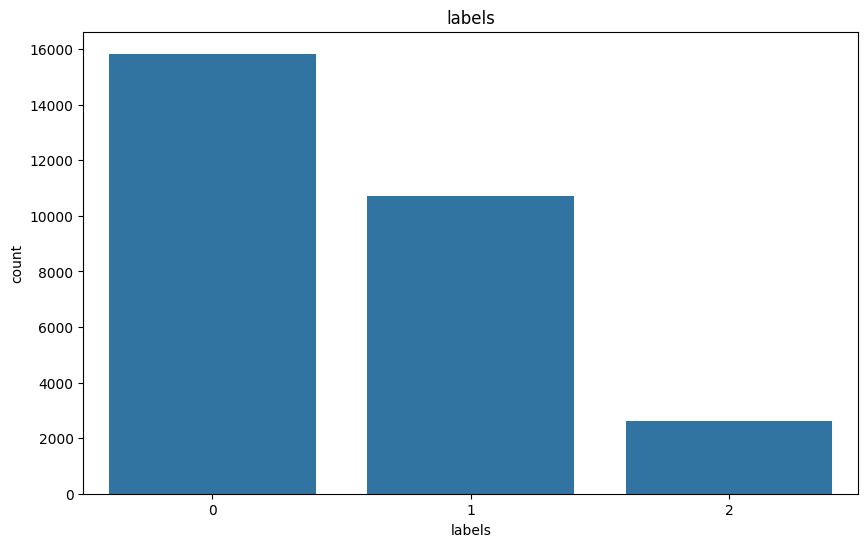

In [8]:
# affichage des données par classement de la colonne 'Allside'
plt.figure(figsize=(10, 6))
sns.countplot(x='labels',  data=df)
plt.title('labels')
plt.show()

In [9]:
##-- Trouver les sources uniques dans le DataFrame
sources_uniques = df['source'].unique()
##- Diviser la liste des sources de manière aléatoire en deux ensembles
sources_train, sources_test = train_test_split(sources_uniques, test_size=0.3, random_state=18) #27

##-- Filtrer les données en fonction des ensembles de sources
train_df = df[df['source'].isin(sources_train)]
test_df = df[df['source'].isin(sources_test)]

train_df = train_df[['labels','text','title']]
test_df = test_df[['labels','text','title']]

##--Separer les données dans des fichiers train et test
train_dataset = datasets.Dataset.from_pandas(train_df)
test_dataset = datasets.Dataset.from_pandas(test_df)

train_dataset = train_dataset.remove_columns(["__index_level_0__"])
test_dataset = test_dataset.remove_columns(["__index_level_0__"])

##-- Exporter en csv pour verifier le ontenu des datasets
# train.to_csv('./splitm-elec/train.csv')
# test.to_csv('./splitm-elec/test.csv')

dataset = datasets.DatasetDict({
    'train': train_dataset,
    'test': test_dataset
})

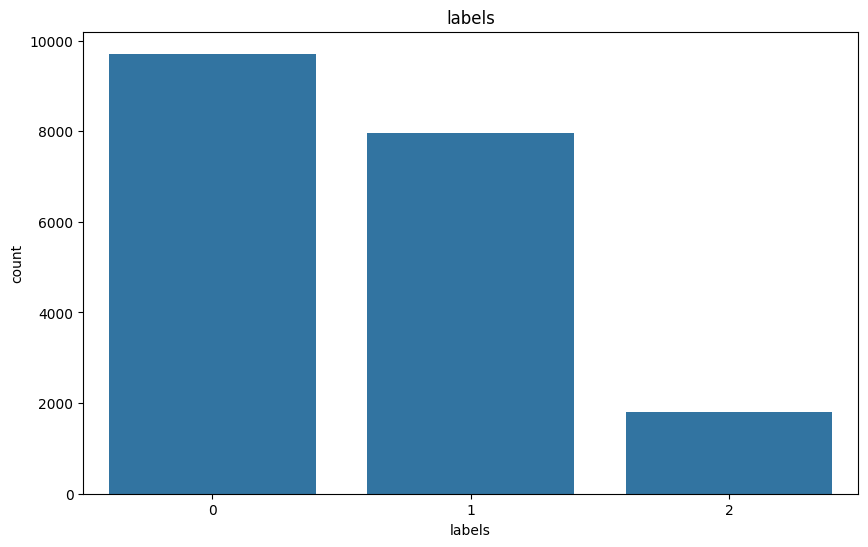

In [10]:
# affichage des données par classement de la colonne 'Allside'
plt.figure(figsize=(10, 6))
sns.countplot(x='labels',  data=train_df)
plt.title('labels')
plt.show()

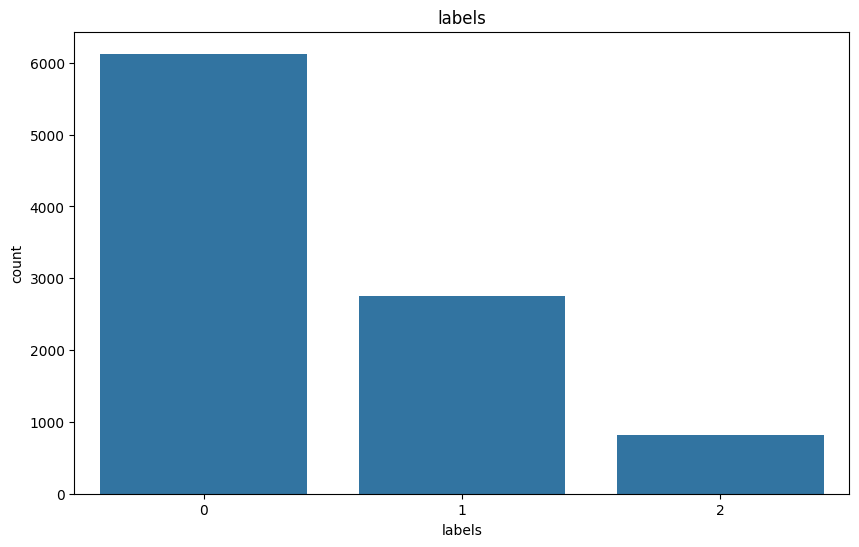

In [11]:
# affichage des données par classement de la colonne 'Allside'
plt.figure(figsize=(10, 6))
sns.countplot(x='labels',  data=test_df)
plt.title('labels')
plt.show()

In [12]:
##-- Tokenisation, partie probablement à revoir

tokenizer = AutoTokenizer.from_pretrained("launch/POLITICS")
#tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
#tokenizer = AutoTokenizer.from_pretrained("FacebookAI/xlm-roberta-base")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Map:   0%|          | 0/19475 [00:00<?, ? examples/s]

Map:   0%|          | 0/9697 [00:00<?, ? examples/s]

In [13]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(15000)) #Modifiez la range si vous voulez réduire le temps de training [0:5075]
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(1500)) # [0:2740]

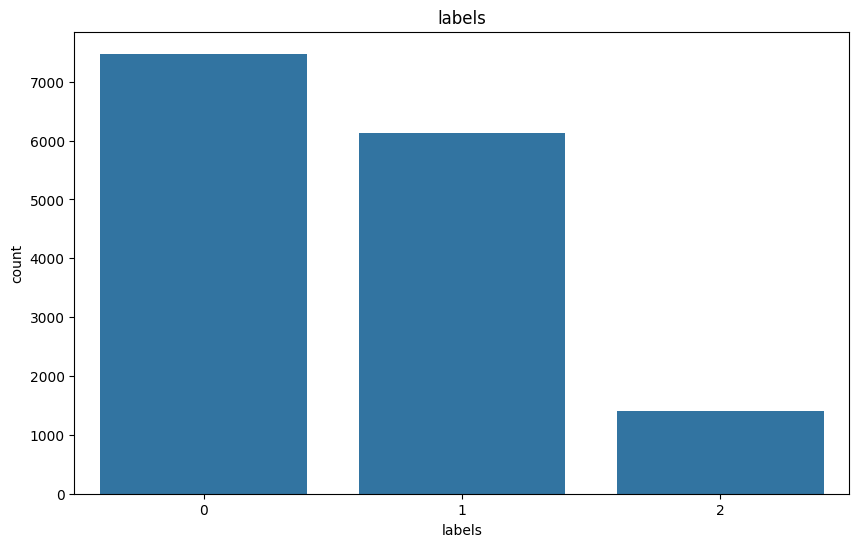

In [14]:
# affichage des données par classement de la colonne 'Allside'
plt.figure(figsize=(10, 6))
sns.countplot(x='labels',  data=pd.DataFrame(small_train_dataset))
plt.title('labels')
plt.show()

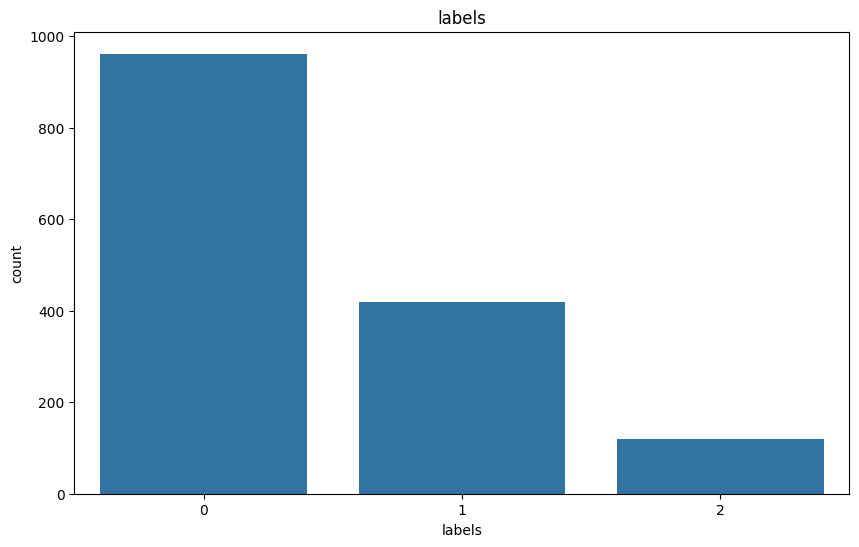

In [15]:
# affichage des données par classement de la colonne 'Allside'
plt.figure(figsize=(10, 6))
sns.countplot(x='labels',  data=pd.DataFrame(small_eval_dataset))
plt.title('labels')
plt.show()

In [16]:
##-- Modele et entrainement

model = AutoModelForSequenceClassification.from_pretrained("launch/POLITICS", num_labels=3)
model.config.hidden_dropout_prob = 0.5
model.config.attention_probs_dropout_prob = 0.5
#model = AutoModelForSequenceClassification.from_pretrained("FacebookAI/xlm-roberta-base",num_labels=3)
training_args = TrainingArguments(output_dir="test_traine5")
metric = evaluate.load("accuracy")


from sklearn.metrics import accuracy_score

training_args = TrainingArguments(
    output_dir="test_trainer5",
    evaluation_strategy="epoch",
    per_device_train_batch_size=16,      # Augmenter la taille du batch
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    learning_rate=1e-4,                  # Augmenter le taux d'apprentissage
    weight_decay=0.01,                   # Ajouter le poids de décroissance
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {"accuracy": accuracy_score(labels, predictions)}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.748800,1.478184,0.428000
2,0.693300,1.159081,0.546667


In [ ]:
from pathlib import Path

MODEL_PATH = Path("model")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "classif_biais_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

In [ ]:
# model.save_pretrained('model')

In [ ]:
##-- Erreurs de prédiction

pred, p_labels, metrics = trainer.predict(small_eval_dataset)

q = 0
distance = []
a = []
t = len(small_eval_dataset[:]["labels"])
for i in range(len(small_eval_dataset[:]["labels"])):
  p = np.argmax(pred[i])
  a.append(p)
  if small_eval_dataset[i]["labels"] != p:
    q = q+1
    distance.append(np.abs(small_eval_dataset[i]["labels"]-p))
    print('texte n°: ',i,', label gold: ',small_eval_dataset[i]["labels"],', label predit:', p, 'distance:', np.abs(small_eval_dataset[i]["labels"]-p))

print("ratio: ",q,"/",t)
print("distance moyenne des erreurs :", np.mean(distance),"(sur 3 classes)")

texte n°:  0 , label gold:  0 , label predit: 1 distance: 1
texte n°:  4 , label gold:  1 , label predit: 0 distance: 1
texte n°:  8 , label gold:  1 , label predit: 0 distance: 1
texte n°:  9 , label gold:  0 , label predit: 1 distance: 1
texte n°:  11 , label gold:  0 , label predit: 1 distance: 1
texte n°:  13 , label gold:  1 , label predit: 0 distance: 1
texte n°:  21 , label gold:  1 , label predit: 0 distance: 1
texte n°:  23 , label gold:  0 , label predit: 2 distance: 2
texte n°:  28 , label gold:  1 , label predit: 0 distance: 1
texte n°:  29 , label gold:  1 , label predit: 0 distance: 1
texte n°:  30 , label gold:  1 , label predit: 0 distance: 1
texte n°:  31 , label gold:  1 , label predit: 0 distance: 1
texte n°:  32 , label gold:  1 , label predit: 2 distance: 1
texte n°:  33 , label gold:  2 , label predit: 1 distance: 1
texte n°:  35 , label gold:  2 , label predit: 1 distance: 1
texte n°:  36 , label gold:  0 , label predit: 2 distance: 2
texte n°:  37 , label gold: 

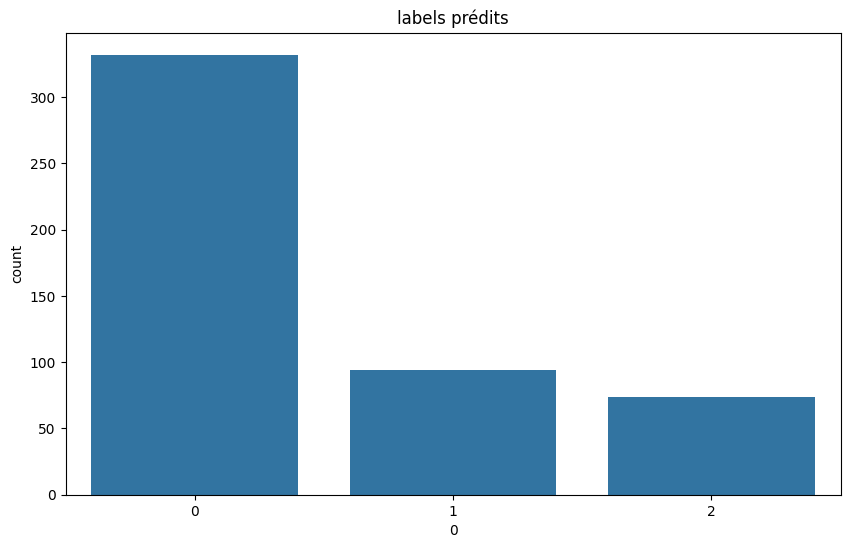

In [ ]:
# affichage des labels prédits
df = pd.DataFrame(a)
plt.figure(figsize=(10, 6))
sns.countplot(x=df[0],  data=df)
plt.title('labels prédits')
plt.show()

In [ ]:
cls_explainer = SequenceClassificationExplainer(
    model,
    tokenizer)

In [ ]:
cls_explainer(small_eval_dataset[15]["text"][0:511])
cls_explainer.visualize()